In [45]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import *
from matplotlib import animation, rc
from IPython.display import HTML

(40, 1)
(40, 1)


<IPython.core.display.Javascript object>


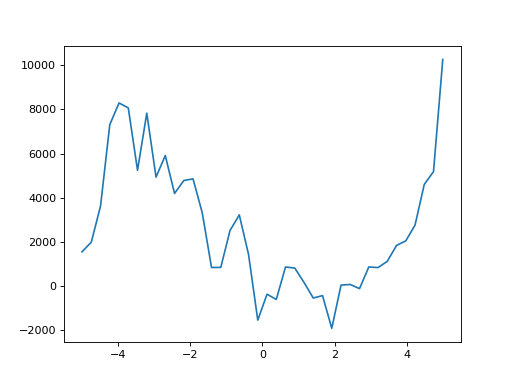

In [48]:
X = np.reshape(np.linspace(-5,5,40),(-1,1))
print(X.shape, flush=True)
Ws = np.random.uniform(-10,10,6)
Y = np.prod([X-Ws[i] for i in range(6)],axis=0) + np.random.normal(0,1000,(40,1))
print(Y.shape, flush=True)

plt.plot(X,Y)
plt.show()

[array([ 1.], dtype=float32)]


<IPython.core.display.Javascript object>


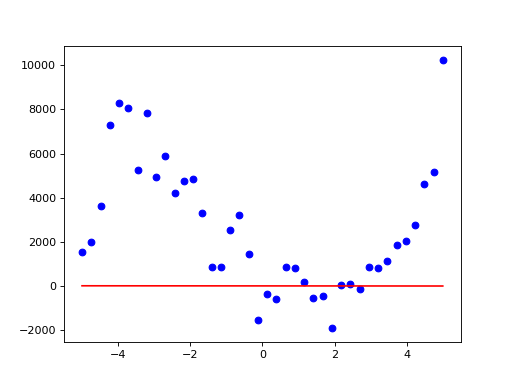

0      ::: 117620.0
1000   ::: 116692.0
2000   ::: 115774.0
3000   ::: 114864.0
4000   ::: 113964.0
5000   ::: 113072.0
6000   ::: 112190.0
7000   ::: 111316.0
8000   ::: 110478.0
9000   ::: 109655.0
10000  ::: 108840.0
11000  ::: 107949.0
12000  ::: 107068.0
13000  ::: 106194.0
14000  ::: 105329.0
15000  ::: 104503.0
16000  ::: 103705.0
17000  ::: 102915.0
18000  ::: 102319.0
19000  ::: 101784.0
20000  ::: 101270.0
21000  ::: 100815.0
22000  ::: 100392.0
23000  ::: 99999.1
24000  ::: 99677.6
25000  ::: 99365.1
26000  ::: 99068.3
27000  ::: 98774.0
28000  ::: 98483.1
29000  ::: 98229.0
30000  ::: 98048.3
31000  ::: 97851.2
32000  ::: 97655.8
33000  ::: 97462.1
34000  ::: 97271.0
35000  ::: 97106.2
36000  ::: 96961.8
37000  ::: 96818.9
38000  ::: 96676.9
39000  ::: 96536.4
40000  ::: 96397.5
41000  ::: 96245.3
42000  ::: 96094.6
43000  ::: 95945.5
44000  ::: 95798.0
45000  ::: 95652.0
46000  ::: 95507.6
47000  ::: 95364.7
48000  ::: 95222.7
49000  ::: 95082.2
50000  ::: 94943.3
51000  :

<IPython.core.display.Javascript object>


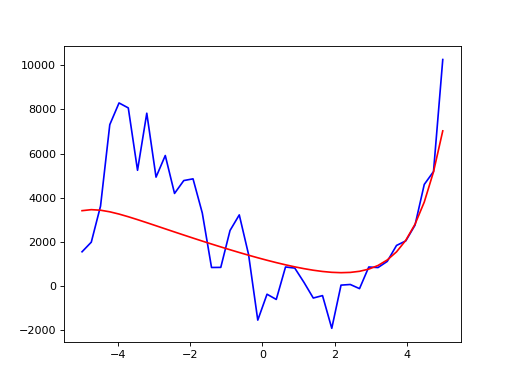

In [60]:


class PolyRegression2d(RestoreableMixin):
    def __init__(self, degree, min_x, max_x, n=1000):
        self.degree = degree
        self._measure_points = tf.reshape(tf.linspace(min_x*1., max_x*1., n), [n,1])
        self.min_x = min_x
        self.max_x = max_x
        self.range = max_x - min_x
        self.far_low = min_x - 100*self.range
        self.far_high = max_x + 100*self.range
        self.initial_zeros = np.random.uniform(self.far_low, self.far_high, degree)
        initial_weights = np.poly(self.initial_zeros)*1e-20
        self.initial_weights = np.reshape(initial_weights,(-1,1)).astype(np.float32)
        self.dx = (max_x-min_x)*1./n
        
        self.train_rate = 0.001
        
        self._init_graph()
        self._init_saver()
        
    def set_train_rate(self,rate):
        self.train_rate = rate
        self.train_step = tf.train.GradientDescentOptimizer(self.train_rate).minimize(self.loss)
        
    def _init_graph(self):
        self.x = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_ = tf.placeholder(tf.float32, shape=[None, 1])
        self.beta = tf.placeholder(tf.float32)
        self.y = tf.constant(0., shape=[1])
        for d in range(self.degree+1):
            self.__dict__["W"+str(d)] = tf.Variable(tf.constant(self.initial_weights[d], shape=[1]))
            self.y = tf.add(tf.multiply(tf.pow(self.x,d),self.__dict__["W"+str(d)]), self.y)
        
        #The length of the line, approximately
        #self.approximate_total_length.eval(feed_dict={self.x:self._measure_points})
        self.dl = tf.pow(tf.pow(self.y,2) + 1,1./2)*self.dx
        self.approximate_total_length = tf.reduce_sum(self.dl)

        self.loss = tf.reduce_sum(tf.abs(self.y-self.y_))# + tf.multiply(self.beta,self.approximate_total_length)
        self.train_step = tf.train.GradientDescentOptimizer(self.train_rate).minimize(self.loss)

class UppingPolyRegression2d(RestoreableMixin):
    def __init__(self, min_x, max_x, n=1000):
        self.degree = 1
        self._measure_points = tf.reshape(tf.linspace(min_x*1., max_x*1., n), [n,1])
        self.min_x = min_x
        self.max_x = max_x
        self.range = max_x - min_x
        self.far_low = min_x - 100*self.range
        self.far_high = max_x + 100*self.range
        initial_weights = [1,-1]
        self.initial_weights = np.reshape(initial_weights,(-1,1)).astype(np.float32)
        self.dx = (max_x-min_x)*1./n
        
        self.train_rate = 0.001
        
        self._init_graph()
        self._init_saver()
        
    def up_degree(self,sess):
        OUT_OF_BOUNDS = 1000
        self.degree += 1
        #max_x ** self.degree * weight should be < 1000 or so...
        new_weight = min(abs(1000./(self.max_x ** self.degree)), abs(1000./(self.min_x ** self.degree)))
        self._add_term(self.degree, new_weight)
        sess.run(self.__dict__["W"+str(self.degree)].initializer)
        
    def _add_term(self, degree, initial_weight):
        self.__dict__["W"+str(degree)] = tf.Variable(tf.constant(initial_weight, shape=[1]))
        self.y = tf.add(tf.multiply(tf.pow(self.x,degree),self.__dict__["W"+str(degree)]), self.y)
        
    def set_train_rate(self,rate):
        self.train_rate = rate
        self.train_step = tf.train.GradientDescentOptimizer(self.train_rate).minimize(self.loss)
        
    def _init_graph(self):
        self.x = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_ = tf.placeholder(tf.float32, shape=[None, 1])
        self.beta = tf.placeholder(tf.float32)
        self.y = tf.constant(0., shape=[1])
        for d in range(self.degree+1):
            self._add_term(d, self.initial_weights[d])
        #The length of the line, approximately
        #self.approximate_total_length.eval(feed_dict={self.x:self._measure_points})
        self.dl = tf.pow(tf.pow(self.y,2) + 1,1./2)*self.dx
        self.approximate_total_length = tf.reduce_sum(self.dl)

        self.loss = tf.reduce_sum(tf.abs(self.y-self.y_))# + tf.multiply(self.beta,self.approximate_total_length)
        self.train_step = tf.train.GradientDescentOptimizer(self.train_rate).minimize(self.loss)


        
DEGREE=1
model = UppingPolyRegression2d(-5,5)
with tf.Session() as sess:
    model.initialize(sess)
    
    def train_eval():
        model.train_step.run(feed_dict={model.x: X, model.y_: Y, model.beta:1.})
        yyy = model.y.eval(feed_dict={model.x:X})
        return yyy
    
    def update_line(num, line):
        #print("step",num,flush=True)
        yyy = train_eval()
        print(yyy)
        line.set_data(X,yyy)
        return line,

    print([sess.run(model.__dict__["W"+str(d)]) for d in range(DEGREE)], flush=True)
    yyy = train_eval()
    fig=plt.figure()
    plt.plot(X,Y,'bo')
    plt.plot(X,yyy,'r-')
    plt.show()

    '''
    fig1 = plt.figure()

    plt.plot(X,Y)
    l, = plt.plot([], [], 'r-')
    plt.xlim(-5, 5)
    plt.xlabel('x')
    plt.title('test')
    line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(l,),
                                       interval=2000, blit=False)
    '''

    #HTML(line_ani.to_jshtml())
    for i in range(250000):
        try:
            if not i%1000:
                print(str(i).ljust(6," "),":::",model.loss.eval(feed_dict={model.x:X,model.y_:Y,model.beta:1.}),flush=True)
                model.set_train_rate(model.train_rate/1.01)
            if not (i+1)%10000:
                model.up_degree(sess)
                model.set_train_rate(0.001)
            yyy = train_eval()
        except KeyboardInterrupt:
            break
    print([sess.run(model.__dict__["W"+str(d)]) for d in range(DEGREE)], flush=True)
    fig=plt.figure()
    plt.plot(X,Y,'b-')
    plt.plot(X,yyy,'r-')
    plt.show()

In [61]:
model.degree

9

In [16]:
print(model.initial_zeros)

[  7.76681684  -5.61855986 -11.5783995    3.2622529   -0.85372095
 -14.24652489  -7.49104809   3.68709734 -14.92561642   6.08042268]


<IPython.core.display.Javascript object>


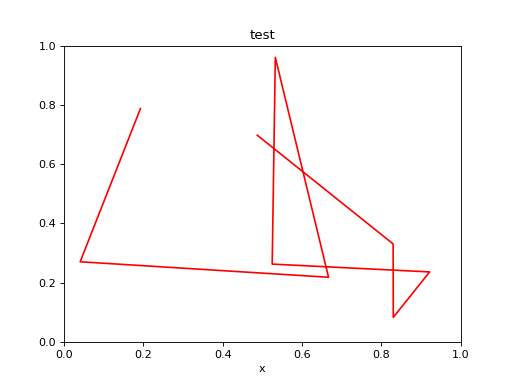

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)

HTML(line_ani.to_jshtml())

In [53]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
N = 100
def f(x,a,b,c):
    return a*x**2+b*x+c

ones = np.ones(N).reshape(-1,1)
x = np.linspace(-10,10,N).reshape(-1,1)
x2 = x**2
X = np.hstack((x2,x,ones))
y = f(x,1,1,1) + np.random.uniform(0,20,N).reshape(-1,1)
reg = linear_model.LinearRegression(fit_intercept=False)
print(reg)
reg.fit(X,y)
print(reg.coef_)
Y = f(x,*reg.coef_[0])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
[[  1.00301879   0.88807574  11.5786101 ]]


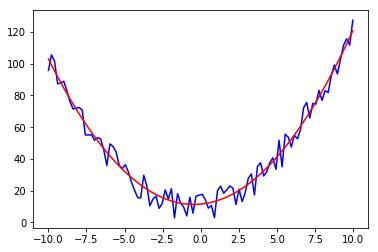

In [54]:
plt.plot(x,y,'b')
plt.plot(x,Y,'r')
plt.show()

In [45]:
X

array([[  1.00000000e+02,  -1.00000000e+01,   1.00000000e+00],
       [  9.60004081e+01,  -9.79797980e+00,   1.00000000e+00],
       [  9.20824406e+01,  -9.59595960e+00,   1.00000000e+00],
       [  8.82460973e+01,  -9.39393939e+00,   1.00000000e+00],
       [  8.44913784e+01,  -9.19191919e+00,   1.00000000e+00],
       [  8.08182838e+01,  -8.98989899e+00,   1.00000000e+00],
       [  7.72268136e+01,  -8.78787879e+00,   1.00000000e+00],
       [  7.37169677e+01,  -8.58585859e+00,   1.00000000e+00],
       [  7.02887460e+01,  -8.38383838e+00,   1.00000000e+00],
       [  6.69421488e+01,  -8.18181818e+00,   1.00000000e+00],
       [  6.36771758e+01,  -7.97979798e+00,   1.00000000e+00],
       [  6.04938272e+01,  -7.77777778e+00,   1.00000000e+00],
       [  5.73921028e+01,  -7.57575758e+00,   1.00000000e+00],
       [  5.43720029e+01,  -7.37373737e+00,   1.00000000e+00],
       [  5.14335272e+01,  -7.17171717e+00,   1.00000000e+00],
       [  4.85766758e+01,  -6.96969697e+00,   1.0000000